# Multivariate Timeseries Data Modeling to predict room occupancy with Gluon

@author: Amulya Badal

In this notebook I attempt my first neural network with Gluon to model timeseries data

## DATASET
Occupancy Detection Dataset
This dataset describes measurements of a room and the objective is to predict whether or not the room is occupied.

There are 20,560 one-minute observations taken over the period of a few weeks. This is a classification prediction problem. There are 7 attributes including various light and climate properties of the room.

The source for the data is credited to Luis Candanedo from UMONS.

Below is a sample of the first 5 rows of data including the header row.

```

"date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"
"1","2015-02-04 17:51:00",23.18,27.272,426,721.25,0.00479298817650529,1
"2","2015-02-04 17:51:59",23.15,27.2675,429.5,714,0.00478344094931065,1
"3","2015-02-04 17:53:00",23.15,27.245,426,713.5,0.00477946352442199,1
"4","2015-02-04 17:54:00",23.15,27.2,426,708.25,0.00477150882608175,1
"5","2015-02-04 17:55:00",23.1,27.2,426,704.5,0.00475699293331518,1
"6","2015-02-04 17:55:59",23.1,27.2,419,701,0.00475699293331518,1

```

The data is provided in 3 files that suggest the splits that may be used for training and testing a model.

In [1]:
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import sklearn

import os

#1. Identify what's the feature in the examples  
X = [
    "date",
    "Temperature",
    "Humidity",
    "Light",
    "CO2",
    "HumidityRatio"
]

#2. Target variable is occupancy
y = [
    "Occupancy"
]



/Users/Amulya/anaconda2/lib/python2.7/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
# Use pandas to load the data
import pandas as pd

training_file_path = "occupancy_data/datatraining.txt"
test_file_path = "occupancy_data/datatest.txt" 
test2_file_path = "occupancy_data/datatest2.txt" 

# TRAINING DATA
print("***** TRAIN DATA *****")

col_names = ["date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"]
data_features = ["date","Temperature","Humidity","Light","CO2","HumidityRatio"]

train_data = pd.read_csv(training_file_path, skiprows=[0], names=col_names)
print train_data.head()

#VALIDATION DATA
val_data = pd.read_csv(test_file_path, sep=",", skiprows=[0], header=None, names=col_names)

#TEST DATA
test_data = pd.read_csv(test2_file_path, sep=",", skiprows=[0], header=None, names=col_names)

***** TRAIN DATA *****
                  date  Temperature  Humidity  Light     CO2  HumidityRatio  \
1  2015-02-04 17:51:00        23.18   27.2720  426.0  721.25       0.004793   
2  2015-02-04 17:51:59        23.15   27.2675  429.5  714.00       0.004783   
3  2015-02-04 17:53:00        23.15   27.2450  426.0  713.50       0.004779   
4  2015-02-04 17:54:00        23.15   27.2000  426.0  708.25       0.004772   
5  2015-02-04 17:55:00        23.10   27.2000  426.0  704.50       0.004757   

   Occupancy  
1          1  
2          1  
3          1  
4          1  
5          1  


In [3]:
print("***** Training DATA *****")
X_train_raw = train_data[data_features]
print(X_train_raw.shape)

y_train = train_data.Occupancy
print(y_train.shape)

# VAL
print("***** Validation DATA *****")

X_val_raw = val_data[data_features]
print(X_val_raw.shape)

y_val = val_data.Occupancy
print(y_val.shape)

print("***** TEST DATA *****")
# Test

X_test_raw = test_data[data_features]
print(X_test_raw.shape)

y_test = test_data.Occupancy
print(y_test.shape)

***** Training DATA *****
(8143, 6)
(8143,)
***** Validation DATA *****
(2665, 6)
(2665,)
***** TEST DATA *****
(9752, 6)
(9752,)


In [4]:
# drop NaN values - always a good idea to remove NaNs from the dataset
#train_data.dropna(axis=0, how='any')
#val_data.dropna(axis=0, how='any')
#test2_data.dropna(axis=0, how='any')

In [5]:
print (train_data.columns)
print (train_data.head(5))

Index([u'date', u'Temperature', u'Humidity', u'Light', u'CO2',
       u'HumidityRatio', u'Occupancy'],
      dtype='object')
                  date  Temperature  Humidity  Light     CO2  HumidityRatio  \
1  2015-02-04 17:51:00        23.18   27.2720  426.0  721.25       0.004793   
2  2015-02-04 17:51:59        23.15   27.2675  429.5  714.00       0.004783   
3  2015-02-04 17:53:00        23.15   27.2450  426.0  713.50       0.004779   
4  2015-02-04 17:54:00        23.15   27.2000  426.0  708.25       0.004772   
5  2015-02-04 17:55:00        23.10   27.2000  426.0  704.50       0.004757   

   Occupancy  
1          1  
2          1  
3          1  
4          1  
5          1  


### Feature Engineering - Lets add new features

Convert to one-hot encoding
- The house is likely to be occupied more on the weekends than weekdays, lets use that as an explicit new feature
- People are likely to be in their house in the evening and night, lets create time buckets

In [6]:
#### Function to create new features
from datetime import datetime


def create_new_features(data):
    time_buckets = []
    weekday = []

    for index, row in data.iterrows():
        parsed_date = datetime.strptime(row['date'], "%Y-%m-%d %H:%M:%S")
        time_bucket = parsed_date.hour % 4 # lets divide in to [day 6-12, afternoon 12-6, evening 6-12, night 12-6]
        time_buckets.append(time_bucket)
        wday = 0 if parsed_date.isoweekday() > 5 else 1
        weekday.append(wday)
    return time_buckets, weekday
    
train_time_buckets, train_weekday = create_new_features(train_data)
val_time_buckets, val_weekday = create_new_features(val_data)
test_time_buckets, test_weekday = create_new_features(test_data)

In [7]:
#Validation dataset did not have any values with occupancy 0. So we are adding one here
val_weekday[-1]=0 #dummy

#### One hot encoding of the Weekday and Time buckets

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def onehot_encode(values):
    new_values = np.array(values)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(new_values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return (onehot_encoded, label_encoder.classes_)

## TRAINING DATA
train_time_bucket_onehot_encoded, train_time_class = onehot_encode(train_time_buckets)
train_weekday_onehot_encoded, train_weekday_class = onehot_encode(train_weekday)
print (train_time_bucket_onehot_encoded, train_time_class)
print (train_weekday_onehot_encoded, train_weekday_class)


## VALIDATION DATA
val_time_bucket_onehot_encoded, val_time_class = onehot_encode(val_time_buckets)
val_weekday_onehot_encoded, val_weekday_class = onehot_encode(val_weekday)
print (val_time_bucket_onehot_encoded, val_time_class)
print (val_weekday_onehot_encoded, val_weekday_class)

## TEST DATA

test_time_bucket_onehot_encoded, test_time_class = onehot_encode(test_time_buckets)
test_weekday_onehot_encoded, test_weekday_class = onehot_encode(test_weekday)
print (test_time_bucket_onehot_encoded, test_time_class)
print (test_weekday_onehot_encoded, test_weekday_class)


(array([[ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.]]), array([0, 1, 2, 3]))
(array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]]), array([0, 1]))
(array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.]]), array([0, 1, 2, 3]))
(array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.]]), array([0, 1]))
(array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       ..., 
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.]]), array([0, 1, 2, 3]))
(array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
      

In [10]:
# Append new features to Train, Validation and Test sets

def add_new_features(arr, w_oh, t_oh):
    # lets ignore the date column for all the rows
    X = arr.values[:, 1:] 
    XW = np.hstack((X, w_oh))
    XTW = np.hstack((XW, t_oh))
    return XTW

X_train = add_new_features(X_train_raw, train_weekday_onehot_encoded, train_time_bucket_onehot_encoded)
X_train.shape


(8143, 11)

In [11]:
# Prepare validation data

X_val = add_new_features(X_val_raw, val_weekday_onehot_encoded, val_time_bucket_onehot_encoded)
X_val.shape

(2665, 11)

In [12]:
X_test = add_new_features(X_test_raw, test_weekday_onehot_encoded, test_time_bucket_onehot_encoded)
X_test.shape

(9752, 11)

In [13]:
# find the number of positive occupancy
y_test.shape, sum(y_test), 1-sum(y_test)/(y_test.shape[0]*1.0)

((9752,), 2049, 0.78988925348646433)

In [42]:
# BASERNN Class 
# This code is copied from https://github.com/sunilmallya/timeseries/blob/master/sagemaker-timeseries/generic_ts.py

import mxnet as mx
import numpy as np
import math
from mxnet import nd, autograd

def detach(hidden):
    if isinstance(hidden, (tuple, list)):
        hidden = [i.detach() for i in hidden]
    else:
        hidden = hidden.detach()
    return hidden

class BaseRNNClassifier(mx.gluon.Block):
    '''
    Extensible RNN class with LSTM that can operate with MXNet NDArray iter or DataLoader.
    Includes fit() function to mimic the symbolic fit() function
    '''
    
    @classmethod
    def get_data(cls, batch, iter_type, ctx):
        ''' get data and label from the iterator/dataloader '''
        if iter_type == 'mxiter':
            X = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
        elif iter_type in ["numpy", "dataloader"]:
            X = batch[0].as_in_context(ctx)
            y = batch[1].as_in_context(ctx)
        else:
            raise ValueError("iter_type must be mxiter or numpy")
        return X, y
    
    @classmethod
    def get_all_labels(cls, data_iterator, iter_type):
        if iter_type == 'mxiter':
            pass
        elif iter_type in ["numpy", "dataloader"]:
            return data_iterator._dataset._label
    
    def __init__(self, ctx):
        super(BaseRNNClassifier, self).__init__()
        self.ctx = ctx

    def build_model(self, n_out, rnn_size=128, n_layer=1):
        self.rnn_size = rnn_size
        self.n_layer = n_layer
        self.n_out = n_out
        
        # LSTM default; #TODO(Sunil): make this generic
        self.lstm = mx.gluon.rnn.LSTM(self.rnn_size, self.n_layer, layout='NTC')
        #self.lstm = mx.gluon.rnn.GRU(self.rnn_size, self.n_layer)
        self.output = mx.gluon.nn.Dense(self.n_out)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = out[:, out.shape[1]-1, :]
        out = self.output(out)
        return out, hidden

    def compile_model(self, loss=None, lr=3E-3):
        self.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        self.criterion = mx.gluon.loss.SoftmaxCrossEntropyLoss()
        self.loss = mx.gluon.loss.SoftmaxCrossEntropyLoss() if loss is None else loss
        self.lr = lr
        self.optimizer = mx.gluon.Trainer(self.collect_params(), 'adam', 
                                          {'learning_rate': self.lr})

    def top_k_acc(self, data_iterator, iter_type='mxiter', top_k=3, batch_size=128):
        batch_pred_list = []
        true_labels = []
        init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
        hidden = [init_state] * 2
        for i, batch in enumerate(data_iterator):
            data, label = BaseRNNClassifier.get_data(batch, iter_type, self.ctx)
            batch_pred = self.forward(data, hidden)
            #batch_pred = mx.nd.argmax(batch_pred, axis=1)
            batch_pred_list.append(batch_pred.asnumpy())
            true_labels.append(label)
        y = np.vstack(batch_pred_list)
        true_labels = np.vstack(true_labels)
        argsorted_y = np.argsort(y)[:,-top_k:]
        return np.asarray(np.any(argsorted_y.T == true_labels, axis=0).mean(dtype='f'))
    
    def evaluate_accuracy(self, data_iterator, metric='acc', iter_type='mxiter', batch_size=128):
        met = mx.metric.Accuracy()
        init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
        hidden = [init_state] * 2
        for i, batch in enumerate(data_iterator):
            data, label = BaseRNNClassifier.get_data(batch, iter_type, self.ctx)
            # Lets do a forward pass only!
            output, hidden = self.forward(data, hidden)
            preds = mx.nd.argmax(output, axis=1)
            met.update(labels=label, preds=preds)
                
        #if self.all_labels is None:
        #    self.all_labels = BaseRNNClassifier.get_all_labels(data_iterator, iter_type)
        #preds = self.predict(data_iterator, iter_type=iter_type, batch_size=batch_size)
        #met.update(labels=mx.nd.array(self.all_labels[:len(preds)]), preds=preds)
        
        return met.get()                   
                    
    def predict(self, data_iterator, iter_type='mxiter', batch_size=128):
        batch_pred_list = []
        init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
        hidden = [init_state] * 2
        for i, batch in enumerate(data_iterator):
            data, label = BaseRNNClassifier.get_data(batch, iter_type, self.ctx)
            output, hidden = self.forward(data, hidden)
            batch_pred_list.append(output.asnumpy())
        #return np.vstack(batch_pred_list)
        return np.argmax(np.vstack(batch_pred_list), 1)
    
    def fit(self, train_data, test_data, epochs, batch_size, verbose=True):
        '''
        @train_data:  can be of type list of Numpy array, DataLoader, MXNet NDArray Iter
        '''
        
        moving_loss = 0.
        total_batches = 0

        train_loss = []
        train_acc = []
        test_acc = []

        iter_type = 'numpy'
        train_iter = None
        test_iter = None
        print "Data type:", type(train_data), type(test_data), iter_type, type(train_data[0])
        
        # Can take MX NDArrayIter, or DataLoader
        if isinstance(train_data, mx.io.NDArrayIter):
            train_iter = train_data
            test_iter = test_data
            iter_type = 'mxiter'
            #total_batches = train_iter.num_data // train_iter.batch_size

        elif isinstance(train_data, list):
            if True: #dummy
            #if isinstance(train_data[0], np.ndarray) and isinstance(train_data[1], np.ndarray):
                X, y = np.asarray(train_data[0]).astype('float32'), np.asarray(train_data[1]).astype('float32')
                tX, ty = np.asarray(test_data[0]).astype('float32'), np.asarray(test_data[1]).astype('float32')
                
                total_batches = X.shape[0] // batch_size
                train_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(X, y), 
                                    batch_size=batch_size, shuffle=True, last_batch='discard')
                test_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(tX, ty), 
                                    batch_size=batch_size, shuffle=False, last_batch='discard')
                
        elif isinstance(train_data, mx.gluon.data.dataloader.DataLoader) and isinstance(test_data, mx.gluon.data.dataloader.DataLoader):
            train_iter = train_data
            test_iter = test_data
            total_batches = len(train_iter)
        else:
            raise ValueError("pass mxnet ndarray or numpy array as [data, label]")

        print "Data type:", type(train_data), type(test_data), iter_type
        print "Sizes", self.n_layer, batch_size, self.rnn_size, self.ctx
        
        for e in range(epochs):
            #print self.lstm.collect_params()

            # reset iterators if of MXNet Itertype
            if iter_type == "mxiter":
                train_iter.reset()
                test_iter.reset()
        
            init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
            hidden = [init_state] * 2                
            #hidden = self.begin_state(func=mx.nd.zeros, batch_size=batch_size, ctx=self.ctx)
            yhat = []
            for i, batch in enumerate(train_iter):
                data, label = BaseRNNClassifier.get_data(batch, iter_type, self.ctx)
                #print "Data Shapes:", data.shape, label.shape
                hidden = detach(hidden)
                with mx.autograd.record(train_mode=True):
                    preds, hidden = self.forward(data, hidden)
                    #print preds[0].shape, hidden[0].shape, label.shape
                    loss = self.loss(preds, label) 
                    yhat.extend(preds)
                loss.backward()                                        
                self.optimizer.step(batch_size)
                preds = mx.nd.argmax(preds, axis=1)
                
                batch_acc = mx.nd.mean(preds == label).asscalar()

                if i == 0:
                    moving_loss = nd.mean(loss).asscalar()
                else:
                    moving_loss = .99 * moving_loss + .01 * mx.nd.mean(loss).asscalar()
                    
                if verbose and i%100 == 0:
                    print('[Epoch {}] [Batch {}/{}] Loss: {:.5f}, Batch acc: {:.5f}'.format(
                          e, i, total_batches, moving_loss, batch_acc))                    
                    
            train_loss.append(moving_loss)
            
            t_acc = self.evaluate_accuracy(train_iter, iter_type=iter_type, batch_size=batch_size)
            train_acc.append(t_acc[1])
            
            tst_acc = self.evaluate_accuracy(test_iter, iter_type=iter_type, batch_size=batch_size)
            test_acc.append(tst_acc[1])

            print("Epoch %s. Loss: %.5f Train Acc: %s Test Acc: %s" % (e, moving_loss, t_acc, tst_acc))
        return train_loss, train_acc, test_acc
                    
    def predict(self, data_iterator, iter_type='mxiter', batch_size=128):
        batch_pred_list = []
        init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
        hidden = [init_state] * 2
        for i, batch in enumerate(data_iterator):
            data, label = BaseRNNClassifier.get_data(batch, iter_type, self.ctx)
            output, hidden = self.forward(data, hidden)
            batch_pred_list.append(output.asnumpy())
        return np.argmax(np.vstack(batch_pred_list), 1)

In [43]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((8143, 11), (8143,), (2665, 11), (2665,))

In [44]:
# Expand dimensions

# RNNs take inputs as (batch_size, time step or step_size or sequence_length, features)
X_train = np.expand_dims(X_train, axis=1)
print X_train.shape

X_val = np.expand_dims(X_val, axis=1)
print X_val.shape

X_test = np.expand_dims(X_test, axis=1)
print X_test.shape

(8143, 1, 11)
(2665, 1, 11)
(9752, 1, 11)


In [60]:
N_CLASS = 2

ctx = mx.cpu(0) #change context to execute on CPU
model = BaseRNNClassifier(ctx)
model.build_model(n_out=N_CLASS, rnn_size=8, n_layer=1)
model.compile_model()
#train_loss, train_acc, test_acc = model.fit([X_train[1:], y_train[1:]], [X_test, y_test], batch_size=32, epochs=25)

#train_loss, train_acc, test_acc = model.fit([X_train, y_train], [X_val, y_val], batch_size=32, epochs=4)
train_loss, train_acc, test_acc = model.fit([X_train, y_train], [X_test, y_test], batch_size=32, epochs=10)

Data type: <type 'list'> <type 'list'> numpy <type 'numpy.ndarray'>
Data type: <type 'list'> <type 'list'> numpy
Sizes 1 32 8 cpu(0)
[Epoch 0] [Batch 0/254] Loss: 0.63319, Batch acc: 0.78125
[Epoch 0] [Batch 100/254] Loss: 0.51897, Batch acc: 0.71875
[Epoch 0] [Batch 200/254] Loss: 0.43227, Batch acc: 0.84375
Epoch 0. Loss: 0.39591 Train Acc: ('accuracy', 0.7947834645669292) Test Acc: ('accuracy', 0.8123972039473685)
[Epoch 1] [Batch 0/254] Loss: 0.35631, Batch acc: 0.90625
[Epoch 1] [Batch 100/254] Loss: 0.33867, Batch acc: 0.81250
[Epoch 1] [Batch 200/254] Loss: 0.30496, Batch acc: 1.00000
Epoch 1. Loss: 0.28885 Train Acc: ('accuracy', 0.9400836614173228) Test Acc: ('accuracy', 0.9272203947368421)
[Epoch 2] [Batch 0/254] Loss: 0.15314, Batch acc: 1.00000
[Epoch 2] [Batch 100/254] Loss: 0.21336, Batch acc: 0.87500
[Epoch 2] [Batch 200/254] Loss: 0.22482, Batch acc: 0.93750
Epoch 2. Loss: 0.22412 Train Acc: ('accuracy', 0.9542322834645669) Test Acc: ('accuracy', 0.9435649671052632)
[Ep

In [74]:
b_size = 24
tX, ty = np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32')
test_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(tX, ty), 
                                    batch_size=b_size, shuffle=False, last_batch='discard')
pred_out = model.predict(test_iter, iter_type="dataloader", batch_size=b_size)

In [75]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print confusion_matrix(y_test[:len(pred_out)], pred_out)

[[7558  145]
 [ 131 1910]]


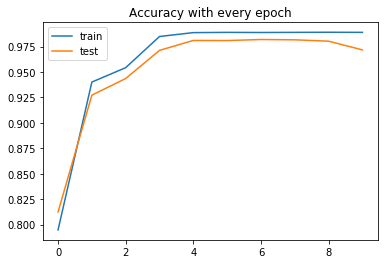

In [61]:
import matplotlib.pyplot as plt

plt.title("Accuracy with every epoch")
plt.plot(train_acc, label="train")
plt.plot(test_acc, label ="test")
plt.legend()
plt.show()

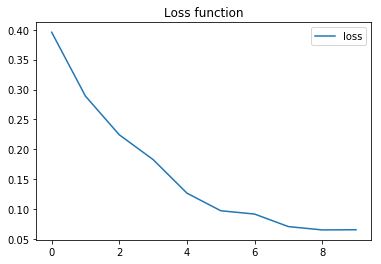

In [76]:
plt.title("Loss function")
plt.plot(train_loss, label="loss")
plt.legend()
plt.show()

## Softmax classifier as a baseline

In [25]:

print X_test.shape

import mxnet as mx
import numpy as np
import math
from mxnet import nd, autograd

N_CLASS = 2
ctx = mx.cpu()
net = mx.gluon.nn.Dense(N_CLASS)

#INIT
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=ctx)
softmax_cross_entropy_loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()

trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## accuracy function
def evaluate_accuracy(t_data, t_label, net, ctx=mx.cpu()):
    num_correct = 0.0
    num_total = len(t_data)
    batch_size = 32
    n_batches = num_total // batch_size
    acc = mx.metric.Accuracy()

    for i in range(n_batches):
        data = mx.nd.array(t_data[i*batch_size:(i+1)*batch_size])
        label = mx.nd.array(t_label[i*batch_size:(i+1)*batch_size])
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]
###
    

epochs = 20
moving_loss = 0.

batch_size = 32
n_batches = len(X_train)//batch_size
loss_sequence = []

for e in range(epochs):
    cumulative_loss = 0
    for i in range(n_batches):
        data = mx.nd.array(X_train[i*batch_size:(i+1)*batch_size])
        label = mx.nd.array(y_train[i*batch_size:(i+1)*batch_size])
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        # Step1. Lets do the forward pass
        with mx.autograd.record():
            output = net(data)
            
            # Step2. Compute the Loss
            loss = softmax_cross_entropy_loss(output, label)
            
        # Step3. Do the backward pass, update the weights    
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    
    loss_sequence.append(cumulative_loss)
    #print e, cumulative_loss
    
    # Step4. Compute the test accuracy
    test_accuracy = evaluate_accuracy(X_test, y_test, net)
    train_accuracy = evaluate_accuracy(X_train, y_train, net)
        
    print "Train Acc:", train_accuracy, "Test Acc:", test_accuracy

 (9752, 11)
Train Acc: 0.811761811024 Test Acc: 0.860711348684
Train Acc: 0.805241141732 Test Acc: 0.858963815789
Train Acc: 0.919045275591 Test Acc: 0.928556743421
Train Acc: 0.926796259843 Test Acc: 0.937602796053
Train Acc: 0.918553149606 Test Acc: 0.927425986842
Train Acc: 0.918184055118 Test Acc: 0.926295230263
Train Acc: 0.909079724409 Test Acc: 0.906352796053
Train Acc: 0.919168307087 Test Acc: 0.928556743421
Train Acc: 0.923720472441 Test Acc: 0.93359375
Train Acc: 0.918184055118 Test Acc: 0.925164473684
Train Acc: 0.912893700787 Test Acc: 0.912828947368
Train Acc: 0.918184055118 Test Acc: 0.925472861842
Train Acc: 0.908956692913 Test Acc: 0.905736019737
Train Acc: 0.915600393701 Test Acc: 0.919407894737
Train Acc: 0.905757874016 Test Acc: 0.902240953947
Train Acc: 0.920644685039 Test Acc: 0.948087993421
Train Acc: 0.849163385827 Test Acc: 0.895970394737
Train Acc: 0.916584645669 Test Acc: 0.949527138158
Train Acc: 0.918184055118 Test Acc: 0.924856085526
Train Acc: 0.8975147637

best accuracy seems to be 94.4%, the RNN achieves a much better accuracy at 98%